In [ ]:
#!pip install category-encoders
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = Path("/content/df2.csv")
df = pd.read_csv(data_dir)
df

,date,city,houseType,status,numberRooms,numberBathrooms,numberKitchens,numberBalconies,houseSpace,elevator,carParking,heating,priceUS
0,2020-01-29,RB,apartment,A,1,1,1,0,NaN,1,1,0,390.0
1,2020-01-29,RB,apartment,A,1,1,1,1,80.0,1,1,0,550.0
2,2020-01-29,RB,apartment,A,3,3,1,2,190.0,1,1,1,1000.0
3,2020-01-29,RB,apartment,A,3,3,1,1,190.0,1,1,1,950.0
4,2020-01-29,RB,apartment,A,3,3,1,3,160.0,1,1,0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2021-03-03,RB,apartment,A,2,2,1,1,120.0,1,1,0,600.0
8120,2021-03-03,RB,apartment,B,3,2,1,1,140.0,1,1,0,500.0
8121,2021-03-03,H,apartment,B,3,2,1,2,150.0,0,0,0,480.0
8122,2021-03-03,N,apartment,A,1,1,1,1,70.0,1,1,1,300.0


In [ ]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df



impute(df)



,date,city,houseType,status,numberRooms,numberBathrooms,numberKitchens,numberBalconies,houseSpace,elevator,carParking,heating,priceUS
0,2020-01-29,RB,apartment,A,1,1,1,0,0.0,1,1,0,390.0
1,2020-01-29,RB,apartment,A,1,1,1,1,80.0,1,1,0,550.0
2,2020-01-29,RB,apartment,A,3,3,1,2,190.0,1,1,1,1000.0
3,2020-01-29,RB,apartment,A,3,3,1,1,190.0,1,1,1,950.0
4,2020-01-29,RB,apartment,A,3,3,1,3,160.0,1,1,0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2021-03-03,RB,apartment,A,2,2,1,1,120.0,1,1,0,600.0
8120,2021-03-03,RB,apartment,B,3,2,1,1,140.0,1,1,0,500.0
8121,2021-03-03,H,apartment,B,3,2,1,2,150.0,0,0,0,480.0
8122,2021-03-03,N,apartment,A,1,1,1,1,70.0,1,1,1,300.0


In [ ]:
# Peek at the values
#display(df)

# Display information about dtypes and missing values

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8124 non-null   object 
 1   city             8124 non-null   object 
 2   houseType        8124 non-null   object 
 3   status           8124 non-null   object 
 4   numberRooms      8124 non-null   int64  
 5   numberBathrooms  8124 non-null   int64  
 6   numberKitchens   8124 non-null   int64  
 7   numberBalconies  8124 non-null   int64  
 8   houseSpace       8124 non-null   float64
 9   elevator         8124 non-null   int64  
 10  carParking       8124 non-null   int64  
 11  heating          8124 non-null   int64  
 12  priceUS          8124 non-null   float64
dtypes: float64(2), int64(7), object(4)
memory usage: 825.2+ KB


None

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
X = df.copy()
y = X.pop("priceUS")

mi_scores = make_mi_scores(X, y)
mi_scores

houseSpace         0.305566
city               0.302346
status             0.187829
numberRooms        0.183755
numberBathrooms    0.179577
elevator           0.144291
heating            0.121258
carParking         0.097993
numberBalconies    0.076805
date               0.044982
houseType          0.008871
numberKitchens     0.006673
Name: MI Scores, dtype: float64

In [ ]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.05]

In [ ]:
X = df.copy()
y = X.pop("priceUS")
X = drop_uninformative(X, mi_scores)

mi_scores = make_mi_scores(X, y)
mi_scores

houseSpace         0.305566
city               0.302346
status             0.187829
numberRooms        0.183755
numberBathrooms    0.179577
elevator           0.144291
heating            0.121258
carParking         0.097993
numberBalconies    0.076805
Name: MI Scores, dtype: float64

In [ ]:
def create_features(df):
    X = df.copy()
    y = X.pop("priceUS")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X


def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X





In [ ]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["featurePlus"] = df.numberBathrooms / df.numberRooms
    X["featurePlus2"] = (df.numberBalconies + df.numberBathrooms) / df.numberRooms
    # This feature ended up not helping performance
    
    return X


def interactions(df):
    X = pd.get_dummies(df.status, prefix="Bldg")
    X = X.mul(df.numberBalconies, axis=0)

    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedstatusHouseSpace"] = df.groupby("status")["houseSpace"].transform("median")
    return X

In [ ]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

In [ ]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [ ]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("priceUS")
    mi_scores = make_mi_scores(X, y)

    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    #Mutual Information
    X = drop_uninformative(X, mi_scores)

    #Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
 
    X = X.join(group_transforms(X))

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["city"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


#df_train, df_test = load_data()
X = create_features(df)
y = df.loc[:, "priceUS"]


0       5.966147
1       6.309918
2       6.907755
3       6.856462
4       6.684612
          ...   
8119    6.396930
8120    6.214608
8121    6.173786
8122    5.703782
8123    6.263398
Name: priceUS, Length: 8124, dtype: float64
[nan nan nan nan nan]


nan

In [ ]:
result = pd.concat([X, y], axis=1)

In [ ]:
result

,city,status,numberRooms,numberBathrooms,numberBalconies,houseSpace,elevator,carParking,heating,featurePlus,featurePlus2,Bldg_A,Bldg_B,Bldg_C,Bldg_D,Bldg_E,MedstatusHouseSpace,city_encoded,priceUS
0,RB,A,1,1,0,0.0,1,1,0,1.000000,1.000000,0,0,0,0,0,100.0,1508.296504,390.0
1,RB,A,1,1,1,80.0,1,1,0,1.000000,2.000000,1,0,0,0,0,100.0,1508.296504,550.0
2,RB,A,3,3,2,190.0,1,1,1,1.000000,1.666667,2,0,0,0,0,100.0,1508.296504,1000.0
3,RB,A,3,3,1,190.0,1,1,1,1.000000,1.333333,1,0,0,0,0,100.0,1508.296504,950.0
4,RB,A,3,3,3,160.0,1,1,0,1.000000,2.000000,3,0,0,0,0,100.0,1508.296504,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,RB,A,2,2,1,120.0,1,1,0,1.000000,1.500000,1,0,0,0,0,100.0,1173.920622,600.0
8120,RB,B,3,2,1,140.0,1,1,0,0.666667,1.000000,0,1,0,0,0,130.0,1173.920622,500.0
8121,H,B,3,2,2,150.0,0,0,0,0.666667,1.333333,0,2,0,0,0,130.0,5721.572350,480.0
8122,N,A,1,1,1,70.0,1,1,1,1.000000,2.000000,1,0,0,0,0,100.0,2748.881764,300.0


In [ ]:
mi_scores = make_mi_scores(X, y)
mi_scores

city_encoded           0.317982
houseSpace             0.308172
city                   0.299743
featurePlus2           0.193269
status                 0.192663
numberBathrooms        0.189170
numberRooms            0.182414
Bldg_A                 0.157809
MedstatusHouseSpace    0.157147
elevator               0.138651
featurePlus            0.130071
heating                0.120698
carParking             0.101214
Bldg_B                 0.095609
numberBalconies        0.067567
Bldg_C                 0.027013
Bldg_D                 0.008117
Bldg_E                 0.005949
Name: MI Scores, dtype: float64

In [ ]:
#result.to_csv (r'dfFE.csv', index = False, header=True)

result.describe()

,numberRooms,numberBathrooms,numberBalconies,houseSpace,elevator,carParking,heating,featurePlus,featurePlus2,Bldg_A,Bldg_B,Bldg_C,Bldg_D,Bldg_E,MedstatusHouseSpace,city_encoded,priceUS
count,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000,7130.000000
mean,2.431697,1.854278,1.018513,98.182048,0.630715,0.676578,0.227209,0.800886,1.239042,0.400561,0.569705,0.043198,0.004909,0.000140,116.651473,1753.921734,499.273973
std,0.840419,0.743004,0.725810,75.358325,0.482645,0.467815,0.419058,0.283184,0.479314,0.643711,0.764430,0.265016,0.090840,0.011843,14.971645,870.618938,183.766436
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,329.625522,100.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1409.767572,375.000000
50%,3.000000,2.000000,1.000000,120.000000,1.000000,1.000000,0.000000,0.666667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,130.000000,1508.296504,493.500000
75%,3.000000,2.000000,1.000000,150.000000,1.000000,1.000000,0.000000,1.000000,1.500000,1.000000,1.000000,0.000000,0.000000,0.000000,130.000000,1567.149325,600.000000
max,6.000000,4.000000,5.000000,1200.000000,1.000000,1.000000,1.000000,3.000000,6.000000,4.000000,5.000000,4.000000,2.000000,1.000000,152.500000,7357.960595,1000.000000


In [ ]:
#drop extreme data
index_names = result[ result['city'] == 'TB' ].index 
index_names
# drop these row indexes 
# from dataFrame 
result.drop(index_names, inplace = True) 

In [ ]:
#drop extreme data
index_names = result[ result['city'] == 'S' ].index 
index_names
# drop these row indexes 
# from dataFrame 
result.drop(index_names, inplace = True) 

In [ ]:
#drop extreme data
index_names = result[ result['priceUS'] < 100 ].index 
index_names
# drop these row indexes 
# from dataFrame 
result.drop(index_names, inplace = True) 

In [ ]:
#drop extreme data
index_names = result[ result['priceUS'] > 1000 ].index 
index_names
# drop these row indexes 
# from dataFrame 
result.drop(index_names, inplace = True) 

In [ ]:

df['houseSpace'] = newdf['houseSpace'].replace(['متر'],'1')

In [ ]:
df['city'] = df['city'].replace(['RB'],'1')
df['city'] = df['city'].replace(['T'],'2')
df['city'] = df['city'].replace(['B'],'3')
df['city'] = df['city'].replace(['N'],'4')
df['city'] = df['city'].replace(['H'],'5')
df['city'] = df['city'].replace(['J'],'6')
df['city'] = df['city'].replace(['JN'],'7')
df['city'] = df['city'].replace(['JR'],'8')
df['city'] = df['city'].replace(['Q'],'9')

In [ ]:
df['status'] = df['status'].replace(['A'],'1')
df['status'] = df['status'].replace(['B'],'2')
df['status'] = df['status'].replace(['C'],'3')
df['status'] = df['status'].replace(['D'],'4')
df['status'] = df['status'].replace(['E'],'5')

In [ ]:
df.drop(df.columns[[13]], axis = 1, inplace = True)
df.drop(df.columns[[13]], axis = 1, inplace = True)
df.drop(df.columns[[13]], axis = 1, inplace = True)

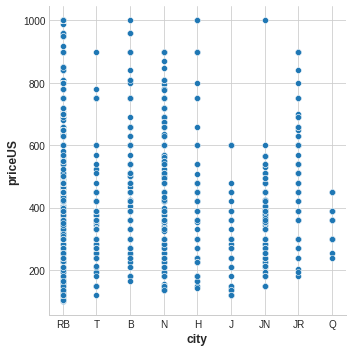

In [ ]:
sns.relplot(x="city", y="priceUS", data=result);

In [ ]:
result.to_csv (r'dfFE11.csv', index = False, header=True)